In [1]:
import sys
sys.path.insert(0, '../../_libs/')
import NEMO_tools as Nts
import Atmos_tools as Ats

In [2]:
import glob
import cartopy
import datetime
import scipy.io
import numpy as np
#import seaborn as sb
import netCDF4 as nc
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.patches as patches
from scipy import signal
from scipy.signal import detrend
from scipy.stats.stats import pearsonr
from NEMO_tools import reporj_NEMOgrid
from mpl_toolkits.basemap import Basemap, cm, addcyclic
% matplotlib inline

In [17]:
def compsit_ttest(x1, x2, sig=0.05):
    from scipy.stats import t as studentt
    N1 = np.size(x1, 0); N2 = np.size(x2, 0); deg_free = N1+N2-2.0
    test_id = np.zeros([np.size(x1, 1), np.size(x1, 2)])
    S = np.sqrt(((N1-1)*np.nanstd(x1, 0)**2+(N2-1)*np.nanstd(x2, 0)**2)/deg_free)
    t = np.abs((np.nanmean(x1, 0)-np.nanmean(x2, 0))/(S*np.sqrt(1.0/N1+1.0/N2)))
    talpha = studentt.ppf(1-sig/2.0, deg_free)   
    test_id[t>=talpha] = 1.0
    return test_id

def compsit(var, t, thres=0, sig=0.05):
    var_p = var[t>thres, :, :]
    var_n = var[t<-thres, :, :]
    test_id = compsit_ttest(var_p, var_n, sig=sig)
    return np.nanmean(var_p, 0)-np.nanmean(var_n, 0), test_id

In [105]:
from dateutil.relativedelta import relativedelta
#base = datetime.datetime(2002, 1, 1)
#date_list = [base + relativedelta(months=x) for x in range(144)]
base = datetime.datetime(2001, 1, 1)
date_list = [base + relativedelta(months=x) for x in range(168)]

In [3]:
RB=[0.25, 0.41, 0.88]    # Royal blue
AM=[0.90, 0.17, 0.31]    # Amathran

In [4]:
coordinate_name=glob.glob('/ocean/yingkai/GEOTRACES/NEMO-CODE/NEMOGCM/CONFIG/ANHA4_OFF/EXP00/mesh_zgr.nc')
coordinate_obj=nc.Dataset(coordinate_name[0])
nav_lon=coordinate_obj.variables['nav_lon'][:]
nav_lat=coordinate_obj.variables['nav_lat'][:]
deptht = coordinate_obj.variables['nav_lev'][:]
e1t = coordinate_obj.variables['e1t'][:]
e2t = coordinate_obj.variables['e2t'][:]
e3t = coordinate_obj.variables['e3t_0'][:]

In [21]:
FName = '/ocean/yingkai/GEOTRACES/BASE04_1m_20020101_20131231_ptrc_T.nc'
ptrc_obj = nc.Dataset(FName)
gridT_mask = ptrc_obj.variables['Ba'][0, 15, :, :]
gridT_mask[gridT_mask>0]=1.0
gridT_mask2 = ptrc_obj.variables['Ba'][0, 30, :, :]
gridT_mask2[gridT_mask2>0]=1.0

In [5]:
MAT = scipy.io.loadmat('../../_data/MAT files/FWC/FWC_EOF.mat')
FWC = MAT['FWC'][:]

In [6]:
FWC[np.isnan(FWC)] = 0
FWC_a = Ats.seasonal_decomp3d(FWC)
FWC_ad = detrend(FWC_a, 0)

FWC_eof = np.transpose(FWC_ad[:, 350:, :], [1, 2, 0])
FWC_eof_wrong = np.transpose(FWC_a[:, 350:, :], [1, 2, 0])

In [230]:
EOFs, PC, expvar = Ats.EOF(FWC_eof, nmode=144, ndim=3, reverse=1)

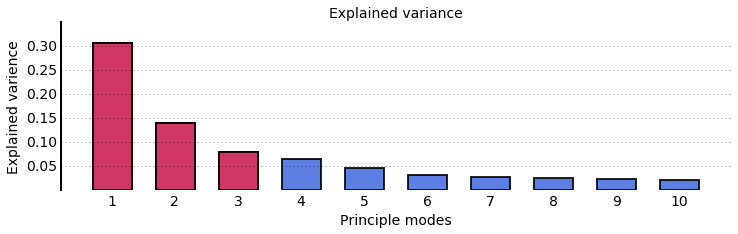

In [163]:
fig=plt.figure(figsize=(12, 3))

ax = fig.gca()
ax.grid(linestyle=':')
ax.xaxis.grid(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False) 
ax.spines["right"].set_visible(False)
ax.set_xlim(0.5, 11.118)
ax.set_xticks(np.arange(1, 11)+0.3)
ax.set_xticklabels(np.arange(1, 11))
ax.set_ylabel('Explained varience', fontsize=14)

ax.set_yticks(np.arange(0.05, 0.35, 0.05))
ax.set_ylim([0, 0.35])

ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
[i.set_linewidth(2.5) for i in ax.spines.itervalues()] 
ax.tick_params(axis="both", which="both", bottom="off", top="off",    
            labelbottom="on", left="off", right="off", labelleft="on")

ax.bar(np.arange(1, 11), expvar[:10], width=0.618, lw=2, alpha=0.85, color=RB)
ax.bar(np.arange(1, 4), expvar[0:3], width=0.618, lw=2, alpha=0.85, color=AM)

[i.set_linewidth(2) for i in ax.spines.itervalues()]
ax.set_xlabel('Principle modes', fontsize=14)
ax.set_title('Explained variance', fontsize=14)

In [170]:
#EOF123 = np.zeros([450, 544, 144])
#for i in range(144):
#    EOF123[:, :, i] = EOFs[:, :, 0]*PC[0, i]+EOFs[:, :, 1]*PC[1, i]+EOFs[:, :, 2]*PC[2, i]

In [236]:
R1 = expvar[0]/(np.sum(expvar[:2]))
R2 = expvar[1]/(np.sum(expvar[:2]))

In [237]:
T = -PC[0, :]*R1 + PC[1, :]*R2
EOF = -EOFs[:, :, 0]*R1 + EOFs[:, :, 1]*R2

In [238]:
# EOF12 = np.zeros([450, 544, 144])
# for i in range(144):
#     EOF12[:, :, i] = EOFs[:, :, 0]*PC[0, i]+EOFs[:, :, 1]*PC[1, i]

In [239]:
MAT = scipy.io.loadmat('../../_data/MAT files/BASE04_tracer_vals_ana2.mat')
Ba = MAT['Ba'][:]
d18O = MAT['d18O'][:]

In [240]:
dBa, _ = compsit(Ba, T_norm, thres=1)
dd18O, _ = compsit(d18O, T_norm, thres=1)

/home/yingkai/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in greater_equal


In [248]:
C1 = plt.cm.PRGn(np.arange(256))[50, 0:3]
C2 = plt.cm.PRGn(np.arange(256))[205, 0:3]

In [288]:
ETOPO2_Arctic=scipy.io.loadmat('../../_libs/ETOPO2_Arctic.mat')
lon_arctic=ETOPO2_Arctic['lon_arctic']
lat_arctic=ETOPO2_Arctic['lat_arctic']
topo_arctic=ETOPO2_Arctic['topo_arctic']

#change resolustion from 2km to 10km
# res=2 * res_unit (km)
# Arctic
res_unit=1
lon_arctic=lon_arctic[0:-1:res_unit, 0:-1:res_unit]
lat_arctic=lat_arctic[0:-1:res_unit, 0:-1:res_unit]
topo_arctic=topo_arctic[0:-1:res_unit, 0:-1:res_unit]*-1 

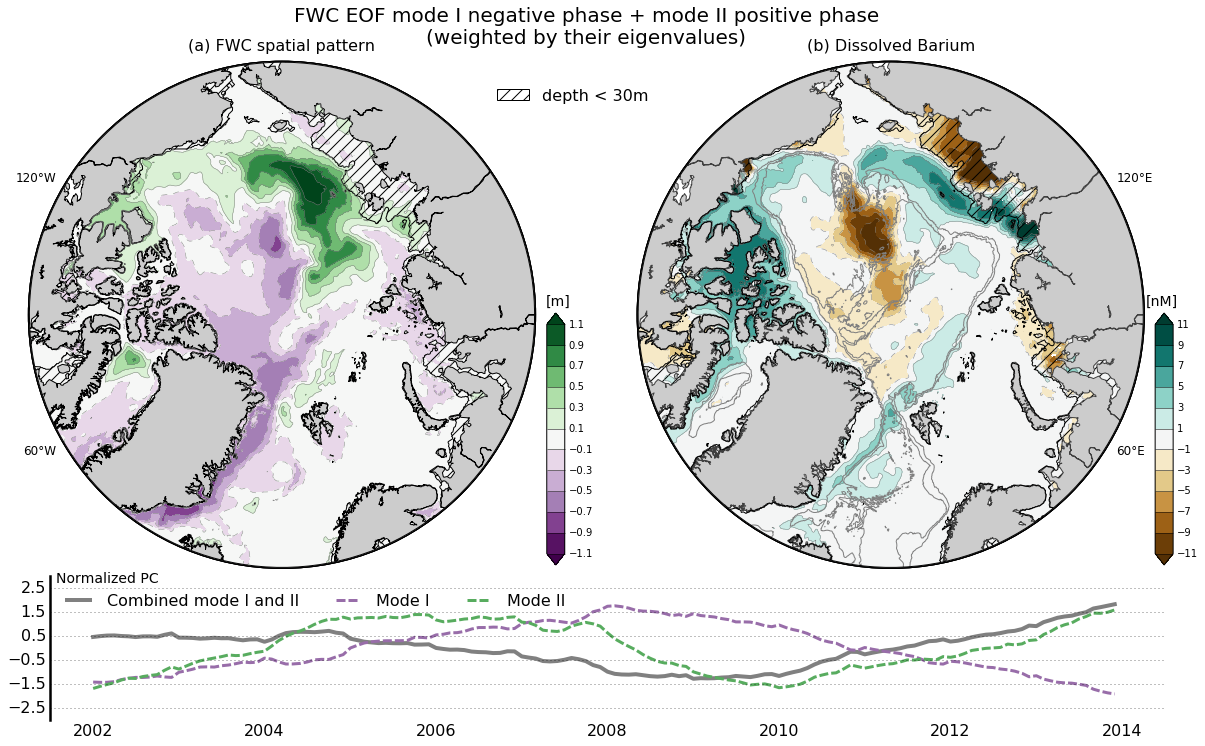

In [291]:
# contour levels
lev_dT = np.array([-11, -9, -7, -5, -3, -1, 1, 3, 5, 7, 9, 11])
#
cmap_scale1 = 1.0
cmap_scale2 = 0.1
# figure size as inches
fig=plt.figure(figsize=(20, 10));
ax=fig.gca()
# set map boundaries
theta = np.linspace(0, 2*np.pi, 150)
center, radius = [0.5, 0.5], 0.498
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
# ======================================== figure a ======================================== #
# background axis
ax_background1 = plt.subplot(1, 2, 1)
patch = patches.PathPatch(circle, lw=4)
ax_background1.add_patch(patch)
ax_background1.axis('off')
# projection axis
ax_proj1 = plt.subplot(1, 2, 1, projection=cartopy.crs.NorthPolarStereo(0))
ax_proj1.set_extent([-180, 180, 65, 90], cartopy.crs.PlateCarree())
ax_proj1.set_boundary(circle, transform=ax_proj1.transAxes)
# basemap @ projection axis
# "proj0" and "proj" --> a hack of basemap's labeling problem 
proj0=Basemap(projection='npstere', resolution='l', boundinglat=65, lon_0=0, round=True, ax=ax_proj1)
proj0.drawmeridians(np.array([240, 300]), labels=[1, 1, 1, 1], fontsize=12, latmax=90, linewidth=0)
proj=Basemap(projection='npstere', resolution='l', boundinglat=65, lon_0=0, round=False, ax=ax_proj1)
proj.drawcoastlines(linewidth=1.0, color='k')
proj.fillcontinents(color='0.8', lake_color=None)
x0, y0 = proj(nav_lon, nav_lat)
#
CS1 = proj.contourf(x0[350:, :], y0[350:, :], EOF, lev_dT*cmap_scale2, cmap=plt.cm.PRGn, extend='both')
CS2 = proj.contourf(x0, y0, gridT_mask, [0, 0.5], hatches=['//'], colors='none')
proj.contour(x0, y0, gridT_mask, [0], linewidths=1.0, colors='k')
proj.contour(x0[350:, :], y0[350:, :], EOF, lev_dT*cmap_scale2, colors='gray', linewidths=0.5)
# colorbar
cax = fig.add_axes([0.485, 0.165, 0.0125, 0.35])
CBar = fig.colorbar(CS1, cax=cax, orientation='vertical')
CBar.set_label('[m]', fontsize=14, labelpad=-35.5, y=1.075, rotation=0)
CBar.ax.tick_params(axis='y', length=18)
CBar.ax.xaxis.set_label_position('top')
CBar.set_ticks(lev_dT*cmap_scale2)

# ======================================== figure b ======================================== #
# background axis
ax_background2 = plt.subplot(1, 2, 2)
patch = patches.PathPatch(circle, lw=4)
ax_background2.add_patch(patch)
ax_background2.axis('off')
# projection axis
ax_proj2 = plt.subplot(1, 2, 2, projection=cartopy.crs.NorthPolarStereo(0))
ax_proj2.set_extent([-180, 180, 65, 90], cartopy.crs.PlateCarree())
ax_proj2.set_boundary(circle, transform=ax_proj2.transAxes)
# basemap @ projection axis
proj0=Basemap(projection='npstere', resolution='l', boundinglat=65, lon_0=0, round=True, ax=ax_proj2)
proj0.drawmeridians(np.array([60, 120]), labels=[1, 1, 1, 1], fontsize=12, latmax=90, linewidth=0)
proj=Basemap(projection='npstere', resolution='l', boundinglat=65, lon_0=0, round=False, ax=ax_proj2)
proj.fillcontinents(color='0.8', lake_color=None)
proj.drawcoastlines(linewidth=1.0, color='0.25')
x0, y0 = proj(nav_lon, nav_lat)
# contour Ba
CS1 = proj.contourf(x0, y0, dBa, lev_dT*cmap_scale1, cmap=plt.cm.BrBG, extend='both')
proj.contour(x0, y0, dBa, lev_dT*cmap_scale1, colors='gray', linewidths=0.5)
CS2 = proj.contourf(x0, y0, gridT_mask, [0, 0.5], hatches=['//'], colors='none')
proj.contour(x0, y0, gridT_mask, [0], linewidths=1.0, colors='k')
#CS3 = proj.contourf(x0, y0, Ba_id, [0.5, 1.0], hatches=['...'], colors='none')
# dep < 30m

topox, topoy = proj(lon_arctic, lat_arctic)
CS=proj.contour(topox, topoy, topo_arctic, [1000, 2000], colors=('gray',), linewidths=(1.0,))

artists, _ = CS2.legend_elements()
labels = ['depth < 30m']
LG = ax_proj1.legend(artists, labels, bbox_to_anchor=(1.25, 0.975), prop={'size':16}); LG.draw_frame(False)
#ax_proj1.text(0.45, 0.85, '', transform=ax.transAxes, fontsize=14)

# Ba colorbar
cax = fig.add_axes([0.9075, 0.165, 0.0125, 0.35])
CBar = fig.colorbar(CS1, cax=cax, orientation='vertical')
CBar.set_label('[nM]', fontsize=14, labelpad=-36, y=1.075, rotation=0)
CBar.ax.tick_params(axis='y', length=18)
CBar.ax.xaxis.set_label_position('top')
CBar.set_ticks(lev_dT*cmap_scale1)
# title
ax_proj1.set_title("(a) FWC spatial pattern", y=1.02, va='center', ha='center', fontsize=16)
ax_proj2.set_title('(b) Dissolved Barium', y=1.02, va='center', ha='center', fontsize=16)
ax_proj1.text(0.5, 1.015, 'FWC EOF mode I negative phase + mode II positive phase\n(weighted by their eigenvalues)',
        va='center', ha='center', transform=ax.transAxes, fontsize=20)
# ======================================== Line graph ======================================= #
# boxes
L = 0.774; H = 0.2; locx=0.14; locy=-0.05
# axises
ax3 = fig.add_axes([locx, locy, L, H])
ax3.grid(linestyle=':')
ax3.xaxis.grid(False)
ax3.spines["top"].set_visible(False)
ax3.spines["bottom"].set_visible(False) 
ax3.spines["right"].set_visible(False)
ax3.xaxis.set_tick_params(labelsize=16)
ax3.yaxis.set_tick_params(labelsize=16)
[j.set_linewidth(2.5) for j in ax3.spines.itervalues()]
#
ax3.set_yticks(np.array([-2.5, -1.5, -0.5, 0.5, 1.5, 2.5])); 
ax3.set_ylim([-3, 3]) 
#ax3.set_ylabel('Normalized PC', fontsize=16)
ax3.set_xlim([date_list[6], date_list[-6]])
ax3.tick_params(axis="both", which="both", bottom="off", top="off",    
                labelbottom="on", left="off", right="off", labelleft="on")
ax3.plot(date_list[12:-12], T, color='gray', lw=4, label='Combined mode I and II')
ax3.plot(date_list[12:-12], PC[0, :], color=C1, ls='--', lw=3.0, dashes=(9, 3), label='Mode I')
ax3.plot(date_list[12:-12], PC[1, :], color=C2, ls='--', lw=3.0, dashes=(9, 3), label='Mode II')
LG = ax3.legend(bbox_to_anchor=(0.475, 0.975), ncol=3, labelspacing=2, prop={'size':16}); LG.draw_frame(False)
ax3.text(0.005, 0.98, 'Normalized PC',
        va='center', ha='left', transform=ax3.transAxes, fontsize=14)
#plt.plot(PC[0, :], '--')
#plt.plot(PC[1, :], '--')
#plt.plot(T, 'k-', lw=3)
#ax_proj2.text(0.027e7, 0.535e7, r"$\mathrm{\delta^{18}O}$", fontsize=20)
#ax_proj2.text(0.027e7, 0.515e7, "d=1.05m", fontsize=16)
# ======================================== Figure export ======================================== #
#fig.savefig('pdf_test4.pdf', dpi=100, orientation='portrait', papertype='a4', format='pdf',
#                bbox_inches='tight', pad_inches=0.1)
#fig.savefig('mode1_mode2_combine_trc.png', dpi=100, orientation='portrait', papertype='a4', format='png',
#                bbox_inches='tight', pad_inches=0.1)